In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

## Commandの使い方

In [3]:
from typing import Literal
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.types import Command

@tool
def search(query: str):
    """searchツールのモック"""
    # This is a placeholder, but don't tell the LLM that...
    if "東京" in query:
        return "10度で曇りです。"
    return "20度で晴れです。"

tools = [search]
tool_node = ToolNode(tools)

model = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0).bind_tools(tools)

def call_model(state: MessagesState) -> Command[Literal['tools', END]]:
    messages = state['messages']
    response = model.invoke(messages)
    if len(response.tool_calls) > 0:
        next_node = "tools"
    else:
        next_node = END
    return Command(goto=next_node, update={"messages": [response]})

In [4]:
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_edge("tools", 'agent')
app = workflow.compile()

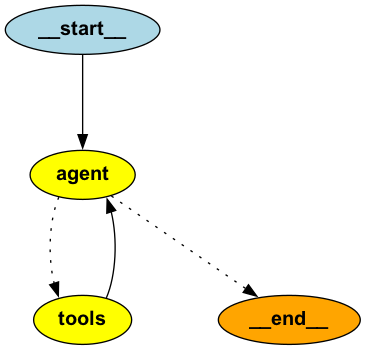

In [5]:
from IPython.display import Image

Image(app.get_graph().draw_png())

In [6]:
response = app.invoke(
    {"messages": [{"role": "user", "content": "東京の天気"}]},
    debug=True
)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [{'content': '東京の天気', 'role': 'user'}]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [{'content': '東京の天気', 'role': 'user'}]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='東京の天気', additional_kwargs={}, response_metadata={}, id='2d41f298-3e25-4ae7-bdb4-e2b10791acd3')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'messages': [HumanMessage(content='東京の天気', additional_kwargs={}, response_metadata={}, id='2d41f298-3e25-4ae7-bdb4-e2b10791acd3')]}
[1:writes] Finished step 1 with writes to 1 channel:
- messages -> [AIMessage(content=[{'text': '東京の天気について情報を得るために、検索ツールを使用できます。以下のように検索を実行してみましょう。', 'type': 'text'}, {'id': 'toolu_01XmVZg93fakGd8h67RwQgny', 'input': {'query': '東京の天気'}, 'name': 'search', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01Y3regVcqeuKa3S2y5e6Ryu', 'model': 'cl

In [7]:
def transfer_to_weather_agent():
    """天気用のAgent"""

tools = [transfer_to_weather_agent]

main_model = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0).bind_tools(tools)

tool_node = ToolNode(tools)

In [8]:
def call_model(state: MessagesState) -> Command[Literal['weather_agent', END]]:
    messages = state['messages']
    response = main_model.invoke(messages)
    if len(response.tool_calls) > 0:
        return Command(goto="weather_agent") # weather_agentを呼び出し
    else:
        return Command(goto=END, update={"messages": [response]})


In [9]:
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("weather_agent", app) # weather_agentは別で定義したappを呼び出している
workflow.add_edge(START, "agent")
multi_agent = workflow.compile()

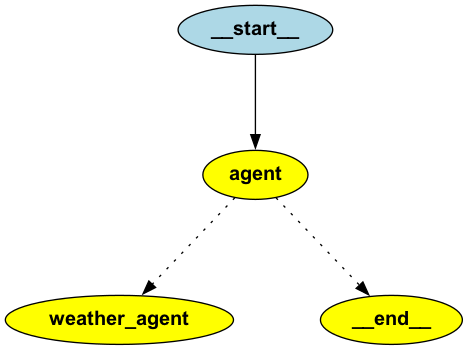

In [10]:
Image(multi_agent.get_graph().draw_png())

In [11]:
response = multi_agent.invoke(
    {"messages": [{"role": "user", "content": "東京の天気"}]},
    debug=True
)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [{'content': '東京の天気', 'role': 'user'}]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [{'content': '東京の天気', 'role': 'user'}]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='東京の天気', additional_kwargs={}, response_metadata={}, id='43ed09d9-3743-47ef-862f-543013e70c46')]}
[1:tasks] Starting 1 task for step 1:
- agent -> {'messages': [HumanMessage(content='東京の天気', additional_kwargs={}, response_metadata={}, id='43ed09d9-3743-47ef-862f-543013e70c46')]}
[1:writes] Finished step 1 with writes to 0 channels:

[1:checkpoint] State at the end of step 1:
{'messages': [HumanMessage(content='東京の天気', additional_kwargs={}, response_metadata={}, id='43ed09d9-3743-47ef-862f-543013e70c46')]}
[2:tasks] Starting 1 task for step 2:
- weather_agent -> {'messages': [HumanMessage(content='東京の天気', additional_kwargs={}, response_metad

## interrupt

In [12]:
import uuid
from typing import TypedDict, Optional

from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command


class State(TypedDict):
    foo: str
    human_value: Optional[str] # interruptでhuman_valueを更新


def node(state: State):
    answer = interrupt(
        "年齢を入力してください"
    )
    print(f"> Received an input from the interrupt: {answer}")
    return {"human_value": answer}


builder = StateGraph(State)
builder.add_node("node", node)
builder.add_edge(START, "node")

# A checkpointer must be enabled for interrupts to work!
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}


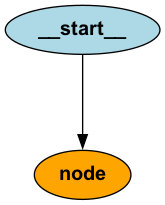

In [13]:
Image(graph.get_graph().draw_png())

In [14]:
for chunk in graph.stream({"foo": "abc"}, config):
    print(chunk)

{'__interrupt__': (Interrupt(value='年齢を入力してください', resumable=True, ns=['node:06db1330-2688-90d1-074b-fb8bb9557535'], when='during'),)}


In [15]:
for chunk in graph.stream(Command(resume="30歳です"), config):
    print(chunk)

> Received an input from the interrupt: 30歳です
{'node': {'human_value': '30歳です'}}
